



#Media Bias on Twitter using Sentiment Analysis [BERT]

The folllowing notebook trains a Sentiment Classifier on the [Tweet Sentiment Extraction](https://www.kaggle.com/c/tweet-sentiment-extraction) dataset available on Kaggle. We'll use the pretrained BERT  model for Sentiment analysis from [Hugging face](https://huggingface.co/transformers/model_doc/bert.html) library.


I have scrapped the data from the twitter accounts of four English News Channels of India CNN News18, Republic TV, NDTV, Times Now. We'll predict the sentiment of these tweets and analyse how one channel is biased towards any particular political party or leaders.


##Table of Contents:
>1. [Setup](#setup)
>2. [Data Preparation](#prep)
>3. [Model](#mod)
>4. [Training](#train)
>5. [Evaluation](#eval)
>6. [Sentiment Prediction](#sent)
>7. [Analysis of media-bias](#ana)


#<a id="setup">Setup</a>

In [ ]:
!pip install transformers


     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 28.9 MB/s 
     |████████████████████████████████| 596 kB 15.7 MB/s 
     |████████████████████████████████| 880 kB 7.1 MB/s 
     |████████████████████████████████| 77 kB 2.8 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=c47214516298d6b01a1d75655e4d5dace17ae3243eeca8bba1ee7c6384e54da6
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("cpu")


Tesla K80


#<a id="prep">Data Preparation</a>

In [ ]:
train = pd.read_csv("drive/MyDrive/train.csv")
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


The dataset contains selected_text and sentiment but we will use only sentiment column and text column for training purpose.

In [ ]:
test = pd.read_csv("drive/MyDrive/test.csv")
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


Converting the sentiment values to integers:-


* neutral - 1

* positive - 2

* negative - 0

In [ ]:
#Removing missing values
train['text'].dropna(axis=0,inplace=True)
train['sentiment'].dropna(axis=0,inplace=True)

#Replacing sentiments with scores
train['sentiment'].replace({'neutral':1,'positive':2,'negative':0},inplace=True)


In [ ]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0
2,088c60f138,my boss is bullying me...,bullying me,0
3,9642c003ef,what interview! leave me alone,leave me alone,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0


In [ ]:
#Removing missing values
test['text'].dropna(axis=0,inplace=True)
test['sentiment'].dropna(axis=0,inplace=True)

#Replacing sentiments with scores
test['sentiment'].replace({'neutral':1,'positive':2,'negative':0},inplace=True)

In [ ]:
MAX_LEN=160
classes = ['negative', 'neutral', 'positive']

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class TwitterDataset(Dataset):
#Creating a Twitter sentiment dataset
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.reviews)  
  
  def __getitem__(self, item):
    review = str(self.reviews[item]) #tweet
    target = self.targets[item] #sentiment
    
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True, # addding [CLS] and [SEP] tokens
      max_length=self.max_len,
      return_token_type_ids=False,
      truncation=True, #trunction for max length
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt', #PyTorch tensors
    )
 
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Splitting the training and testing data

In [ ]:
d_train, d_test = train_test_split(
  train,
  test_size=0.1,
  random_state=RANDOM_SEED
)
d_val, d_test = train_test_split(
  test,
  test_size=0.5,
  random_state=RANDOM_SEED
)
len(d_train)

24732

In [ ]:
def dataloader(dataframe, tokenizer, max_len, batch_size):
#dataloader for pytorch dataset

  dataset = TwitterDataset(
    reviews = dataframe.text.to_numpy(), #converting to numpy array
    targets = dataframe.sentiment.to_numpy(),  #converting to numpy array
    max_len=max_len, # setting the maximum length
    tokenizer=tokenizer,
    
  )

  return DataLoader(
    dataset,
    num_workers=4,
    batch_size=batch_size,
  )


In [ ]:
BATCH_SIZE = 16
train_dataloader = dataloader(d_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_dataloader = dataloader(d_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_dataloader = dataloader(d_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#<a id='mod'>Model</a>

In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=False)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class Classifier(nn.Module):
  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3) #######
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    #using only [CLS] embedding, ignoring sequence output
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
data = next(iter(train_dataloader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
model = Classifier(len(classes))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

#<a id="train">Training</a>

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
len(d_val)

1767

In [ ]:
#%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_dataloader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(d_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_dataloader,
    loss_fn,
    device,
    len(d_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.574750346882223 accuracy 0.7653242762413068


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.49579265619720425 accuracy 0.7979626485568762

Epoch 2/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.3759391791998068 accuracy 0.861272844897299


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5620703747546351 accuracy 0.7973967176004528

Epoch 3/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.2549018144600315 accuracy 0.9173944687045124


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.7490451671015304 accuracy 0.7934352009054896

Epoch 4/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.18370934649018805 accuracy 0.9483664887595019


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.9427228567299543 accuracy 0.7917374080362196

Epoch 5/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.13503897918472885 accuracy 0.9648229015041242


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 1.081613345059088 accuracy 0.787209960384833



In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_dataloader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

    negative       0.76      0.79      0.78       484
     neutral       0.76      0.75      0.75       720
    positive       0.83      0.82      0.83       563

    accuracy                           0.78      1767
   macro avg       0.79      0.79      0.79      1767
weighted avg       0.78      0.78      0.78      1767



#<a id="sent">Sentiment Prediction<a>

I have used the [Twitter Scrapper](https://dev.to/natterstefan/scrape-tweets-from-twitter-profiles-without-using-twitter-s-api-47n7) for scraping the latest 5000 tweets of every channel.

---



Creating Democrat and Republican Dataset 

In [ ]:
NBCDemocrat1 = pd.read_csv("drive/MyDrive/nbcobamaunique.csv",index_col=[0])
NBCDemocrat2 = pd.read_csv("drive/MyDrive/nbcpellosiunique.csv",index_col=[0])
NBCDemocrat3 = pd.read_csv("drive/MyDrive/nbchillaryunique.csv",index_col=[0])
NBCDemocrat4 = pd.read_csv("drive/MyDrive/nbcJBunique.csv",index_col=[0])
NBCDemocrat = pd.concat([NBCDemocrat1, NBCDemocrat2 ,NBCDemocrat3,NBCDemocrat4])
# NBCRepublic = pd.DataFrame({'text_id': NBCRepublic['conversation_id'],
#                    'text': NBCRepublic["tweet_correct"]
#                    })
FoxDemocrat1 = pd.read_csv("drive/MyDrive/foxObamaunique.csv",index_col=[0])
FoxDemocrat2 = pd.read_csv("drive/MyDrive/foxpellosiunique.csv",index_col=[0])
FoxDemocrat3 = pd.read_csv("drive/MyDrive/foxHillaryunique.csv",index_col=[0])
FoxDemocrat4 = pd.read_csv("drive/MyDrive/foxJBunique.csv",index_col=[0])
FoxDemocrat = pd.concat([FoxDemocrat1, FoxDemocrat2 ,FoxDemocrat3,FoxDemocrat4])


NBCDemocrat["tweet_correct"]=NBCDemocrat["tweet"].str.replace("\@\w+[,]|\@\w+|[,]\@\w+", "")
NBCDemocrat["tweet_correct"]=NBCDemocrat["tweet_correct"].str.replace("[^a-zA-Z0-9]", " ")
NBCDemocrat['conversation_id']

NBCDemocrat= pd.DataFrame({'text_id': NBCDemocrat['conversation_id'],
                   'text': NBCDemocrat["tweet_correct"],'channel':NBCDemocrat['name']
                   })
NBCDemocrat['Obama'] = NBCDemocrat['text'].str.contains('Obama' or 'obama' or 'Barack Obama',case=False).astype(int)
NBCDemocrat['Obama'] .astype(int).sum()


NBCDemocrat['Joe Biden'] = NBCDemocrat['text'].str.contains('Biden' or 'Joe Biden',case=False).astype(int)
NBCDemocrat['Joe Biden'] .astype(int).sum()

NBCDemocrat['Pelosi'] = NBCDemocrat['text'].str.contains('Pelosi' or 'pelosi' or 'Nancy Pelosi',case=False).astype(int)
NBCDemocrat['Pelosi'].astype(int).sum()

NBCDemocrat['Hillary'] = NBCDemocrat['text'].str.contains('Hillary Clinton',case=False).astype(int)
NBCDemocrat['Hillary'] .astype(int).sum()

NBCDemocrat.to_csv('NBCDemocrat.csv')


################################################

FoxDemocrat["tweet_correct"]=FoxDemocrat["tweet"].str.replace("\@\w+[,]|\@\w+|[,]\@\w+", "")
FoxDemocrat["tweet_correct"]=FoxDemocrat["tweet"].str.replace("[^a-zA-Z0-9]", " ")
FoxDemocrat['conversation_id']

FoxDemocrat= pd.DataFrame({'text_id': FoxDemocrat['conversation_id'],
                   'text': FoxDemocrat["tweet_correct"],'channel':FoxDemocrat['name']
                   })
FoxDemocrat['Obama'] = FoxDemocrat['text'].str.contains('Obama' or 'Barack' or 'Barack Obama',case=False).astype(int)
FoxDemocrat['Obama'] .astype(int).sum()

FoxDemocrat['Joe Biden'] = FoxDemocrat['text'].str.contains('Joe Biden' or 'Biden',case=False).astype(int)
FoxDemocrat['Joe Biden'] .astype(int).sum()


FoxDemocrat['Pelosi'] = FoxDemocrat['text'].str.contains('Pelosi' or 'Nancy Pelosi',case=False).astype(int)
FoxDemocrat['Pelosi'] .astype(int).sum()

FoxDemocrat['Hillary'] = FoxDemocrat['text'].str.contains('Hillary' or 'Hillary Clinton',case=False).astype(int)
FoxDemocrat['Hillary'] .astype(int).sum()

FoxDemocrat.to_csv('FoxDemocrat.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
NBCRepublic1 = pd.read_csv("drive/MyDrive/nbctrumpunique.csv",index_col=[0])
NBCRepublic2 = pd.read_csv("drive/MyDrive/nbcDesantisunique.csv",index_col=[0])
NBCRepublic3 = pd.read_csv("drive/MyDrive/nbcMitch McConnellunique.csv",index_col=[0])
NBCRepublic4 = pd.read_csv("drive/MyDrive/nbccruzunique.csv",index_col=[0])
NBCRepublic = pd.concat([NBCRepublic1, NBCRepublic2 ,NBCRepublic3,NBCRepublic4])
# NBCRepublic = pd.DataFrame({'text_id': NBCRepublic['conversation_id'],
#                    'text': NBCRepublic["tweet_correct"]
#                    })
FoxRepublic1 = pd.read_csv("drive/MyDrive/foxtrumpunique.csv",index_col=[0])
FoxRepublic2 = pd.read_csv("drive/MyDrive/foxDesantisunique.csv",index_col=[0])
FoxRepublic3 = pd.read_csv("drive/MyDrive/foxMitchunique.csv",index_col=[0])
FoxRepublic4 = pd.read_csv("drive/MyDrive/foxcruzunique.csv",index_col=[0])
FoxRepublic = pd.concat([FoxRepublic1, FoxRepublic2 ,FoxRepublic3,FoxRepublic4])


NBCRepublic["tweet_correct"]=NBCRepublic["tweet"].str.replace("\@\w+[,]|\@\w+|[,]\@\w+", "")
NBCRepublic["tweet_correct"]=NBCRepublic["tweet_correct"].str.replace("[^a-zA-Z0-9]", " ")
NBCRepublic['conversation_id']

NBCRepublic= pd.DataFrame({'text_id': NBCRepublic['conversation_id'],
                   'text': NBCRepublic["tweet_correct"],'channel':NBCRepublic['name']
                   })
NBCRepublic['Trump'] = NBCRepublic['text'].str.contains('Trump' or 'trump' or 'Donald Trump',case=False).astype(int)
NBCRepublic['Trump'] .astype(int).sum()


NBCRepublic['Cruz'] = NBCRepublic['text'].str.contains('Cruz' or 'Ted Cruz' or 'Senator Cruz',case=False).astype(int)
NBCRepublic['Cruz'].astype(int).sum()

NBCRepublic['McConnell'] = NBCRepublic['text'].str.contains('McConnell' or 'Mitch' or 'Governor McConnell',case=False).astype(int)
NBCRepublic['McConnell'] .astype(int).sum()

NBCRepublic['DeSantis'] = NBCRepublic['text'].str.contains('DeSantis' or 'Ron DeSantis' or 'Senator DeSantis',case=False).astype(int)
NBCRepublic['DeSantis'] .astype(int).sum()

NBCRepublic.to_csv('NBCRepublic.csv')


################################################

#FoxRepublic["tweet_correct"]=FoxRepublic["tweet"].str.replace("\@\w+[,]|\@\w+|[,]\@\w+", "")
FoxRepublic["tweet_correct"]=FoxRepublic["tweet"].str.replace("[^a-zA-Z0-9]", " ")
FoxRepublic['conversation_id']

FoxRepublic= pd.DataFrame({'text_id': FoxRepublic['conversation_id'],
                   'text': FoxRepublic["tweet_correct"],'channel':FoxRepublic['name']
                   })
FoxRepublic['Trump'] = FoxRepublic['text'].str.contains('Trump' or 'trump' or 'Donald Trump',case=False).astype(int)
FoxRepublic['Trump'] .astype(int).sum()


FoxRepublic['Cruz'] = FoxRepublic['text'].str.contains('Cruz' or 'Ted Cruz' or 'Senator Cruz',case=False).astype(int)
FoxRepublic['Cruz'] .astype(int).sum()

FoxRepublic['McConnell'] = FoxRepublic['text'].str.contains('McConnell' or 'Mitch' or 'Governor McConnell',case=False).astype(int)
FoxRepublic['McConnell'] .astype(int).sum()

FoxRepublic['DeSantis'] = FoxRepublic['text'].str.contains('DeSantis' or 'Ron DeSantis' or 'Senator DeSantis',case=False).astype(int)
FoxRepublic['DeSantis'] .astype(int).sum()

FoxRepublic.to_csv('FoxRepublic.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: The default value of regex will change from True to False in a future version.


Making sure the number of dataset are equally distributed to avoid bias

In [ ]:
FoxRepublic['DeSantis'].astype(int).sum()

40

In [ ]:
NBCDemocrat['Pelosi'].astype(int).sum()

40

In [ ]:
len(FoxRepublic),len(FoxDemocrat)

(160, 160)

In [ ]:
len(NBCRepublic),len(NBCDemocrat)

(160, 160)

In [ ]:
Republic=pd.concat([NBCRepublic,FoxRepublic])
Democrat=pd.concat([NBCDemocrat,FoxDemocrat])
len(Republic),len(Democrat)

(320, 320)

In [ ]:
Republic['Cruz'] .astype(int).sum(),Democrat['Pelosi'] .astype(int).sum()

(80, 80)

**Data Description**
>1. channel - Name of the news channel.
>2. tweet   - Text of the tweet.
>3.Trump     - Tweet contains keyword 'Trump' or not
>3.Hillary- Tweet contains keyword 'Hillary' or not
>3.McColin     - Tweet contains keyword 'McColin' or not
>3.Biden    - Tweet contains keyword 'Biden' or not
>3.Pelosi     - Tweet contains keyword 'Pelosi' or not
>3.Cruz     - Tweet contains keyword 'Cruz' or not

In [ ]:
pred = []
for tweet in Republic['text']:
  encoded_review = tokenizer.encode_plus(
  tweet,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  truncation=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  pred.append(classes[prediction])

Republic['sentiment'] = pred

pred = []
for tweet in Democrat['text']:
  encoded_review = tokenizer.encode_plus(
  tweet,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  truncation=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  pred.append(classes[prediction])

Democrat['sentiment'] = pred


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
Democrat

,text_id,text,channel,Obama,Joe Biden,Pelosi,Hillary,sentiment
0,1510893706869673986,Former President Obama will return to the Whit...,NBC News,1,1,0,0,neutral
1,1508353459686416384,Donald Glover confirms that Malia Obama is in ...,NBC News,1,0,0,0,neutral
2,1508277966438113283,Donald Glover confirms that Malia Obama is in ...,NBC News,1,0,0,0,neutral
3,1507832530355036166,Donald Glover confirms that Malia Obama is in ...,NBC News,1,0,0,0,neutral
4,1503113945476964357,Former President Obama says he has tested posi...,NBC News,1,0,0,0,neutral
...,...,...,...,...,...,...,...,...
35,1494977559666302981,OPINION TuckerCarlson What does Joe Biden s...,Fox News,0,1,0,0,neutral
36,1494762391896084484,OPINION TuckerCarlson What does Joe Biden s...,Fox News,0,1,0,0,neutral
37,1494703256072855559,TuckerCarlson What does Joe Biden s Russia...,Fox News,0,1,0,0,neutral
38,1494134504696340480,Mark Levin No accident Trudeau instituting ...,Fox News,0,1,0,0,positive


In [ ]:
Republic

,text_id,text,channel,Trump,Cruz,McConnell,DeSantis,sentiment
0,1513471695159447554,Rep Cheney says the Jan 6 committee has enou...,NBC News,1,0,0,0,neutral
1,1513438721428926466,Rep Cheney says the Jan 6 committee has enou...,NBC News,1,0,0,0,neutral
2,1513240659980922884,Rep Cheney says the Jan 6 committee has enou...,NBC News,1,0,0,0,neutral
3,1513147557114961927,Former President Trump endorses Dr Mehmet Oz ...,NBC News,1,0,0,0,neutral
4,1513109818323709954,Former President Trump is sitting on more than...,NBC News,1,0,0,0,negative
...,...,...,...,...,...,...,...,...
35,1470223906787188737,Sen Klobuchar pivots to honor Bob Dole when J...,Fox News,0,1,0,0,neutral
36,1468722055436648450,Ted Cruz Russian invasion of Ukraine would be...,Fox News,0,1,0,0,negative
37,1466502836385165313,Ted Cruz says Women s Tennis Association has ...,Fox News,0,1,0,0,neutral
38,1462496031690477573,Ted Cruz says US should not boycott Beijing Ol...,Fox News,0,1,0,0,negative


Creating a new column 'relevant', it will be 1 or 0 depending upon whether it contains any keywords or not

In [ ]:
Republic['relevant']=Republic.sum(axis=1)
binary=[]
for t in Republic['relevant']:
  if t>0:
    binary.append(1)
  else:
    binary.append(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [ ]:
Republic['relevant'] =binary
Republic.head()

,text_id,text,channel,Trump,Cruz,McConnell,DeSantis,sentiment,relevant
0,1513471695159447554,Rep Cheney says the Jan 6 committee has enou...,NBC News,1,0,0,0,neutral,1
1,1513438721428926466,Rep Cheney says the Jan 6 committee has enou...,NBC News,1,0,0,0,neutral,1
2,1513240659980922884,Rep Cheney says the Jan 6 committee has enou...,NBC News,1,0,0,0,neutral,1
3,1513147557114961927,Former President Trump endorses Dr Mehmet Oz ...,NBC News,1,0,0,0,neutral,1
4,1513109818323709954,Former President Trump is sitting on more than...,NBC News,1,0,0,0,negative,1


In [ ]:
Democrat['relevant'] =binary
Democrat.head()

,text_id,text,channel,Obama,Joe Biden,Pelosi,Hillary,sentiment,relevant
0,1510893706869673986,Former President Obama will return to the Whit...,NBC News,1,1,0,0,neutral,1
1,1508353459686416384,Donald Glover confirms that Malia Obama is in ...,NBC News,1,0,0,0,neutral,1
2,1508277966438113283,Donald Glover confirms that Malia Obama is in ...,NBC News,1,0,0,0,neutral,1
3,1507832530355036166,Donald Glover confirms that Malia Obama is in ...,NBC News,1,0,0,0,neutral,1
4,1503113945476964357,Former President Obama says he has tested posi...,NBC News,1,0,0,0,neutral,1


#<a id="ana">Analysis of Media-Bias<a>

In [ ]:
num_relevant = Republic.relevant.sum()
num_total = Republic.shape[0]
print('Number of relevant tweets: %s' % num_relevant)
print('Total number of tweets: %s' % num_total)
print('Percentage of relevant tweets: %0.2f%%' % (100*num_relevant/num_total))

Number of relevant tweets: 320
Total number of tweets: 320
Percentage of relevant tweets: 100.00%


The chosen topics are covered in of the total 20,000 tweets. Let's see to what extent those topics are covered overall by each channel

##Relative topic Coverage
> Despite having equal number of tweets that include each candidate, as one candidate could be mentioned in another candidates mention, it shows that how important each topic is to each channel. We will plot the count of tweets about every topic for each channel.

80 111


Text(0.5, 1.0, 'Cruz')

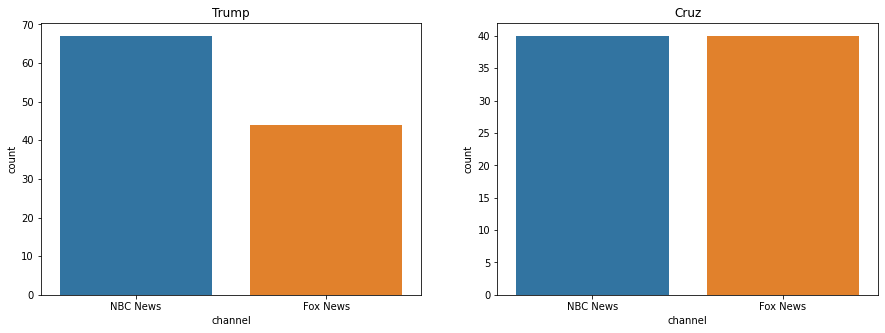

In [ ]:
Trump=Republic.loc[Republic['Trump'] == 1]
Cruz=Republic.loc[Republic['Cruz'] == 1]
McConell=Republic.loc[Republic['McConnell'] == 1]
DeSantis=Republic.loc[Republic['DeSantis'] == 1]
print(len(Cruz),len(Trump))
fig, axes = plt.subplots(1, 2,figsize=(15,5))
sns.countplot(x="channel", data=Trump, ax=axes[0]).set_title("Trump")
sns.countplot(x='channel',data=Cruz, ax=axes[1]).set_title("Cruz")


In [ ]:
Republic

,text_id,text,channel,Trump,Cruz,McConnell,DeSantis,sentiment,relevant
0,1513471695159447554,Rep Cheney says the Jan 6 committee has enou...,NBC News,1,0,0,0,neutral,1
1,1513438721428926466,Rep Cheney says the Jan 6 committee has enou...,NBC News,1,0,0,0,neutral,1
2,1513240659980922884,Rep Cheney says the Jan 6 committee has enou...,NBC News,1,0,0,0,neutral,1
3,1513147557114961927,Former President Trump endorses Dr Mehmet Oz ...,NBC News,1,0,0,0,neutral,1
4,1513109818323709954,Former President Trump is sitting on more than...,NBC News,1,0,0,0,negative,1
...,...,...,...,...,...,...,...,...,...
35,1470223906787188737,Sen Klobuchar pivots to honor Bob Dole when J...,Fox News,0,1,0,0,neutral,1
36,1468722055436648450,Ted Cruz Russian invasion of Ukraine would be...,Fox News,0,1,0,0,negative,1
37,1466502836385165313,Ted Cruz says Women s Tennis Association has ...,Fox News,0,1,0,0,neutral,1
38,1462496031690477573,Ted Cruz says US should not boycott Beijing Ol...,Fox News,0,1,0,0,negative,1


Trump is mentioned more than Hillary,  by NBC. This shows how much more mentioned Trump is but not if News stations are biased towards or against him

90 81


Text(0.5, 1.0, 'Hillary')

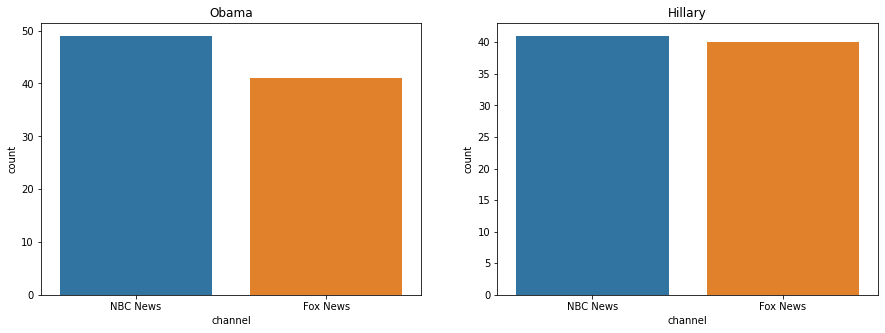

In [ ]:
Obama=Democrat.loc[Democrat['Obama'] == 1]
Hillary=Democrat.loc[Democrat['Hillary'] == 1]
Biden=Democrat.loc[Democrat['Joe Biden'] == 1]
Pelosi=Democrat.loc[Democrat['Pelosi'] == 1]
print(len(Obama),len(Hillary))
fig, axes = plt.subplots(1, 2,figsize=(15,5))
# plt.ylim(0, 100)
sns.countplot(x="channel", data=Obama, ax=axes[0]).set_title("Obama")
sns.countplot(x='channel',data=Hillary, ax=axes[1]).set_title("Hillary")


It shows that NBC talks more about Obama than Hillary

##Sentiment towards Topics

We will show the sentiments of News Channels towards our Topics by ploting percentage of their positive tweets and negative tweets out of their total tweets about a topic.

### Percentage Positive Tweets

In [ ]:
Biden

,text_id,text,channel,Obama,Joe Biden,Pelosi,Hillary,sentiment,relevant
0,1510893706869673986,Former President Obama will return to the Whit...,NBC News,1,1,0,0,neutral,1
5,1496947731792896002,Former President Obama blasts Russia s illega...,NBC News,1,1,0,0,positive,1
10,1488918919649935372,President Biden will announce a relaunch of a ...,NBC News,1,1,0,0,neutral,1
30,1436680844547080195,Former President Clinton former first lady Hi...,NBC News,1,1,0,1,neutral,1
3,1254733009888202752,NEW Speaker Nancy Pelosi is endorsing Joe Bid...,NBC News,0,1,1,0,positive,1
...,...,...,...,...,...,...,...,...,...
35,1494977559666302981,OPINION TuckerCarlson What does Joe Biden s...,Fox News,0,1,0,0,neutral,1
36,1494762391896084484,OPINION TuckerCarlson What does Joe Biden s...,Fox News,0,1,0,0,neutral,1
37,1494703256072855559,TuckerCarlson What does Joe Biden s Russia...,Fox News,0,1,0,0,neutral,1
38,1494134504696340480,Mark Levin No accident Trudeau instituting ...,Fox News,0,1,0,0,positive,1


In [ ]:
Hillary.groupby(['channel','sentiment']).sum()

text_id  Obama  Joe Biden  Pelosi  Hillary  relevant
channel  sentiment                                                           
Fox News negative   2.205950e+19    0.0        0.0     0.0     15.0      15.0
         neutral    3.215645e+19    1.0        0.0     0.0     22.0      22.0
         positive   4.237858e+18    0.0        0.0     0.0      3.0       3.0
NBC News negative   9.872643e+18    0.0        2.0     0.0      7.0       7.0
         neutral    3.912135e+19    9.0       13.0     0.0     30.0      30.0
         positive   5.125266e+18    0.0        2.0     0.0      4.0       4.0

In [ ]:
Trump.groupby(['channel','sentiment']).sum()

text_id  Trump  Cruz  McConnell  DeSantis  relevant
channel  sentiment                                                          
Fox News negative   2.539267e+19   17.0   0.0        2.0       0.0      17.0
         neutral    2.870864e+19   19.0   1.0        0.0       0.0      19.0
         positive   1.194314e+19    8.0   0.0        1.0       0.0       8.0
NBC News negative   4.029768e+19   27.0   1.0        1.0       0.0      27.0
         neutral    4.994165e+19   38.0  13.0        9.0       1.0      38.0
         positive   2.697077e+18    2.0   0.0        1.0       1.0       2.0

In [ ]:
Cruz.groupby(['channel','sentiment']).sum()

text_id  Trump  Cruz  McConnell  DeSantis  relevant
channel  sentiment                                                          
Fox News negative   2.681724e+19    0.0  18.0        0.0       0.0      18.0
         neutral    2.987578e+19    1.0  20.0        0.0       0.0      20.0
         positive   2.981007e+18    0.0   2.0        0.0       0.0       2.0
NBC News negative   8.504338e+18    1.0   7.0        0.0       0.0       7.0
         neutral    3.112265e+19   13.0  28.0        0.0       0.0      28.0
         positive   5.561104e+18    0.0   5.0        0.0       0.0       5.0

In [ ]:

McConell=Republic.loc[Republic['McConnell'] == 1]
McConell

,text_id,text,channel,Trump,Cruz,McConnell,DeSantis,sentiment,relevant
0,1362066544805748739,Opinion Carol C Lam How Mitch McConnell s ...,NBC News,1,0,1,0,neutral,1
1,1361994078083235840,Opinion Carol C Lam How Mitch McConnell s ...,NBC News,1,0,1,0,neutral,1
2,1360707287053193217,Senate Minority Leader Mitch McConnell departs...,NBC News,1,0,1,0,neutral,1
3,1351675857056751617,Sen Mitch McConnell indicates in letter to Re...,NBC News,0,0,1,0,neutral,1
4,1338878261011636226,Opinion Rep Katie Porter Why Mitch McConne...,NBC News,0,0,1,0,neutral,1
...,...,...,...,...,...,...,...,...,...
35,1047850111328559104,senatemajldr Mitch McConnell files motion to...,Fox News,0,0,1,0,neutral,1
36,1047666399685087232,Senate Majority Leader Mitch McConnell speaks ...,Fox News,0,0,1,0,neutral,1
37,1047529683313745925,In remarks on the Senate Floor Wednesday se...,Fox News,0,0,1,0,negative,1
38,1047187265632587776,senatemajldr Mitch McConnell prepares for fu...,Fox News,0,0,1,0,neutral,1


In [ ]:
channels=['NBC News','Fox News']


**Trump vs Hillary**

Text(0.5, 1.0, 'Hillary')

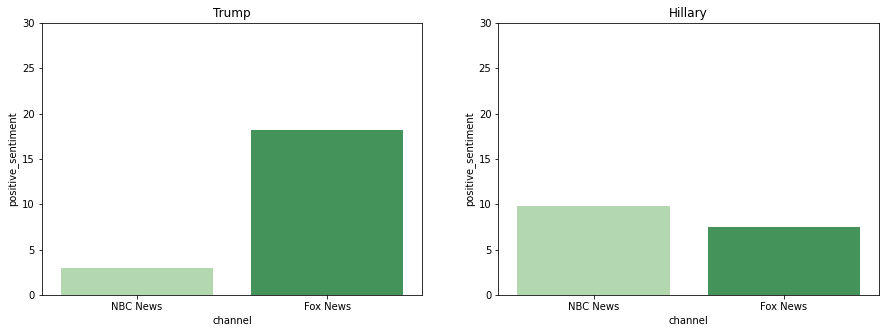

In [ ]:
groups = Trump.groupby(['channel','sentiment'])
group = Trump.groupby('channel')
a=[]
a.append(100*len(groups.get_group(('NBC News','positive')))/len(group.get_group('NBC News')))
a.append(100*len(groups.get_group(('Fox News','positive')))/len(group.get_group('Fox News')))

groups = Hillary.groupby(['channel','sentiment'])
group = Hillary.groupby('channel')
b=[]
b.append(100*len(groups.get_group(('NBC News','positive')))/len(group.get_group('NBC News')))
b.append(100*len(groups.get_group(('Fox News','positive')))/len(group.get_group('Fox News')))



fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].set_ylim(0,30)
axes[1].set_ylim(0,30)

d=pd.DataFrame({'channel':channels,'positive_sentiment':a})
e=pd.DataFrame({'channel':channels,'positive_sentiment':b})


sns.barplot(x='channel',y='positive_sentiment',data=d,ax=axes[0], palette=("Greens")).set_title("Trump")
sns.barplot(x='channel',y='positive_sentiment',data=e,ax=axes[1], palette=("Greens")).set_title("Hillary")


[12.903225806451612]


Text(0.5, 1.0, 'Biden')

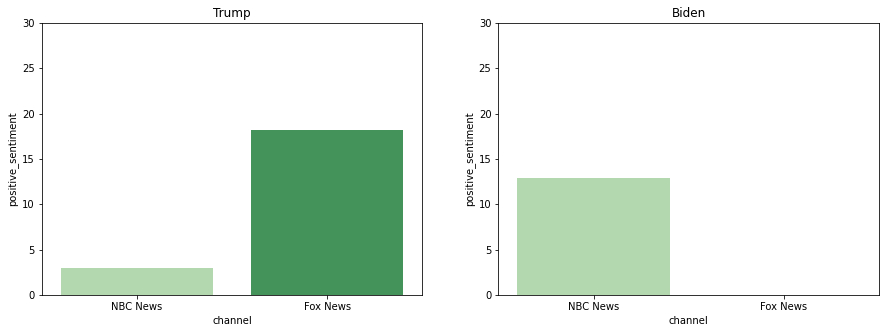

In [ ]:
groups = Trump.groupby(['channel','sentiment'])
group = Trump.groupby('channel')
a=[]
a.append(100*len(groups.get_group(('NBC News','positive')))/len(group.get_group('NBC News')))
a.append(100*len(groups.get_group(('Fox News','positive')))/len(group.get_group('Fox News')))

groups = Biden.groupby(['channel','sentiment'])
group = Biden.groupby('channel')
b=[]
b.append(100*len(groups.get_group(('NBC News','positive')))/len(group.get_group('NBC News')))
print(b)
#b.append(100*len(groups.get_group(('Fox News','positive')))/len(group.get_group('Fox News')))
b.append(0) #Fox News only has negative and neutral sentiment towards Biden
#print(groups.get_group((('Fox News','positive'))))
fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].set_ylim(0,30)
axes[1].set_ylim(0,30)

d=pd.DataFrame({'channel':channels,'positive_sentiment':a})
e=pd.DataFrame({'channel':channels,'positive_sentiment':b})


sns.barplot(x='channel',y='positive_sentiment',data=d,ax=axes[0], palette=("Greens")).set_title("Trump")
sns.barplot(x='channel',y='positive_sentiment',data=e,ax=axes[1], palette=("Greens")).set_title("Biden")

[10.0]


Text(0.5, 1.0, 'Pelosi')

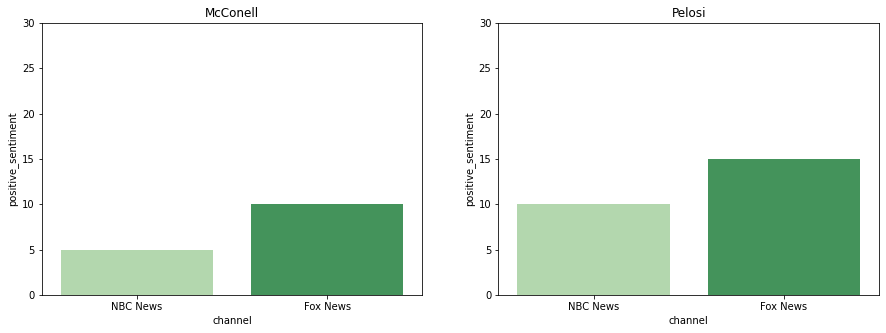

In [ ]:
groups = McConell.groupby(['channel','sentiment'])
group = McConell.groupby('channel')
a=[]
a.append(100*len(groups.get_group(('NBC News','positive')))/len(group.get_group('NBC News')))
a.append(100*len(groups.get_group(('Fox News','positive')))/len(group.get_group('Fox News')))

groups = Pelosi.groupby(['channel','sentiment'])
group = Pelosi.groupby('channel')
b=[]
b.append(100*len(groups.get_group(('NBC News','positive')))/len(group.get_group('NBC News')))
print(b)
b.append(100*len(groups.get_group(('Fox News','positive')))/len(group.get_group('Fox News')))
#b.append(0) #Fox News only has negative and neutral sentiment towards Biden
#print(groups.get_group((('Fox News','positive'))))
fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].set_ylim(0,30)
axes[1].set_ylim(0,30)

d=pd.DataFrame({'channel':channels,'positive_sentiment':a})
e=pd.DataFrame({'channel':channels,'positive_sentiment':b})


sns.barplot(x='channel',y='positive_sentiment',data=d,ax=axes[0], palette=("Greens")).set_title("McConell")
sns.barplot(x='channel',y='positive_sentiment',data=e,ax=axes[1], palette=("Greens")).set_title("Pelosi")

[10.204081632653061]


Text(0.5, 1.0, 'Obama')

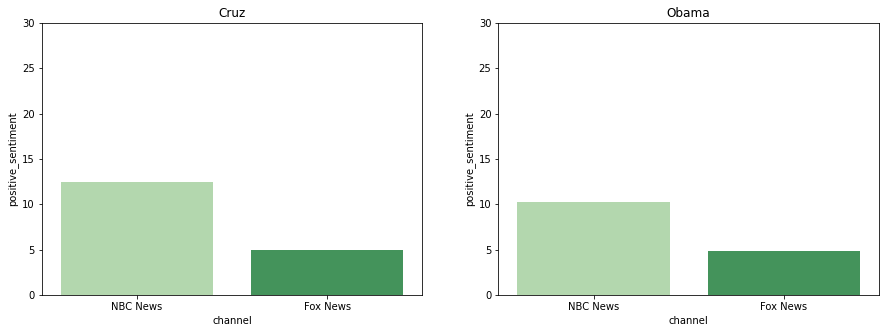

In [ ]:
groups = Cruz.groupby(['channel','sentiment'])
group = Cruz.groupby('channel')
a=[]
a.append(100*len(groups.get_group(('NBC News','positive')))/len(group.get_group('NBC News')))
a.append(100*len(groups.get_group(('Fox News','positive')))/len(group.get_group('Fox News')))

groups = Obama.groupby(['channel','sentiment'])
group = Obama.groupby('channel')
b=[]
b.append(100*len(groups.get_group(('NBC News','positive')))/len(group.get_group('NBC News')))
print(b)
b.append(100*len(groups.get_group(('Fox News','positive')))/len(group.get_group('Fox News')))
#b.append(0) #Fox News only has negative and neutral sentiment towards Biden
#print(groups.get_group((('Fox News','positive'))))
fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].set_ylim(0,30)
axes[1].set_ylim(0,30)

d=pd.DataFrame({'channel':channels,'positive_sentiment':a})
e=pd.DataFrame({'channel':channels,'positive_sentiment':b})


sns.barplot(x='channel',y='positive_sentiment',data=d,ax=axes[0], palette=("Greens")).set_title("Cruz")
sns.barplot(x='channel',y='positive_sentiment',data=e,ax=axes[1], palette=("Greens")).set_title("Obama")

In [ ]:
channels

['NBC News', 'Fox News']

* It shows that all the four News Channel talks more positive about Narendra Trump than Hillary
* NDTV is having the maximum positive tweets percent of 28.38%.
* Hillary is having very few positive tweets from all the four channels.
* Combined positive percentage of Hillary ( 5.43 + 8.8 + 6.25 + 6.66 ) is less than NDTV's ( 28.38 %) for Narendra Trump.


**BJP vs Congress**

###Percentage Negative Tweets

**Trump vs Hillary**

* We can see clearly in the above figure that the all the News channels talks so much negative about Hillary.
* But for Narendra Trump that is not the case, only Republic TV is having a significant negative percent and rest all are below 20%.

**BJP vs Congress**

* Here also BJP is having very low percent of negative tweets from all the channels.
* Congress is not so popular among these channels becuse ever channel is having about 25% negative tweets which is very low than that of BJP.
* We can also see that for BJP most of the tweets are neutral (because both the positive and negative count is low).

#<a id="ref"> References</a>

* [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

* [Hugging Face Transformers](https://huggingface.co/transformers/)

* [Text Classification | Sentiment Analysis with BERT using huggingface](https://www.youtube.com/watch?time_continue=2055&v=8N-nM3QW7O0&feature=emb_title)

* [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pNBCRepublic/1905.05583.pNBCRepublic)
